## Problem statement 

Company XYZ is a worldwide e-commerce site with localized versions of the site.

A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish-speaking countries had the same translation of the site which was written by a Spaniard. Therefore, they agreed to try a test where each country would have its own translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users written by a Mexican and so on. Obviously, nothing would change for users from Spain.

After they run the test however, they are really surprised because the test is negative. That is, it appears that the non-highly localized translation was doing better!

You are asked to:

* Confirm that test is actually negative. I.e., the old version of the site with just one translation across Spain and LatAm performs better

* Explain why that might be happening. Are the localized translations really worse?

* If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and results can be trusted.

In [2]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.simplefilter('ignore')

## 1. Load data

In [3]:
test=pd.read_csv('/Users/angelawu/Documents/Datasets - DS/test_table.csv')
test.describe(include='all')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
count,453321.000000,453321,453321,453321,453321,181877,453321,453321.000000,453321.000000
unique,NaN,5,3,2,3,5,7,NaN,NaN
top,NaN,12/4/2015,Ads,Web,ES,Facebook,Android_App,NaN,NaN
freq,NaN,141163,181877,251565,377547,68425,155135,NaN,NaN
mean,499937.514728,NaN,NaN,NaN,NaN,NaN,NaN,0.049579,0.476446
std,288665.193436,NaN,NaN,NaN,NaN,NaN,NaN,0.217073,0.499445
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,249816.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,500019.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
75%,749522.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000


In [4]:
# find the time span to conduct the AB testing
print(test['date'].min())
print(test['date'].max())

11/30/2015
12/4/2015


Per test table: 
* The ratio of test group is 47.6%, which means the test and control group is quite balanced. 
* ad_channel has null values, which should stand for the case that users did not visit via an ad.

In [5]:
user=pd.read_csv('/Users/angelawu/Documents/Datasets - DS/users_table.csv')
user.describe(include='all')

,user_id,sex,age,country
count,452867.000000,452867,452867.000000,452867
unique,NaN,2,NaN,17
top,NaN,M,NaN,Mexico
freq,NaN,264485,NaN,128484
mean,499944.805166,NaN,27.130740,NaN
std,288676.264784,NaN,6.776678,NaN
min,1.000000,NaN,18.000000,NaN
25%,249819.000000,NaN,22.000000,NaN
50%,500019.000000,NaN,26.000000,NaN
75%,749543.000000,NaN,31.000000,NaN


Per user table:
* Male is the majority user of the website
* There are 17 uniques countries with the business and Mexico is the top country
* age is among the normal distribution
    

### 2. Data Preprocess

#### 2.1 Merge two tables 
* there are 453321 users in the test table and it's more than the user table, which means there are some users missing in the users table. 
* We can use test table as left table so that no data is lost after merging. 

In [6]:
df=test.merge(user,on='user_id',how='left')
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


### 3. First question : Investigate if the test is actually negative

[Text(0, 0, 'Spain'),
 Text(1, 0, 'Costa Rica'),
 Text(2, 0, 'Nicaragua'),
 Text(3, 0, 'Colombia'),
 Text(4, 0, 'El Salvador'),
 Text(5, 0, 'Mexico'),
 Text(6, 0, 'Peru'),
 Text(7, 0, 'Chile'),
 Text(8, 0, 'Venezuela'),
 Text(9, 0, 'Guatemala'),
 Text(10, 0, 'Honduras'),
 Text(11, 0, 'Ecuador'),
 Text(12, 0, 'Paraguay'),
 Text(13, 0, 'Bolivia'),
 Text(14, 0, 'Panama'),
 Text(15, 0, 'Argentina'),
 Text(16, 0, 'Uruguay')]

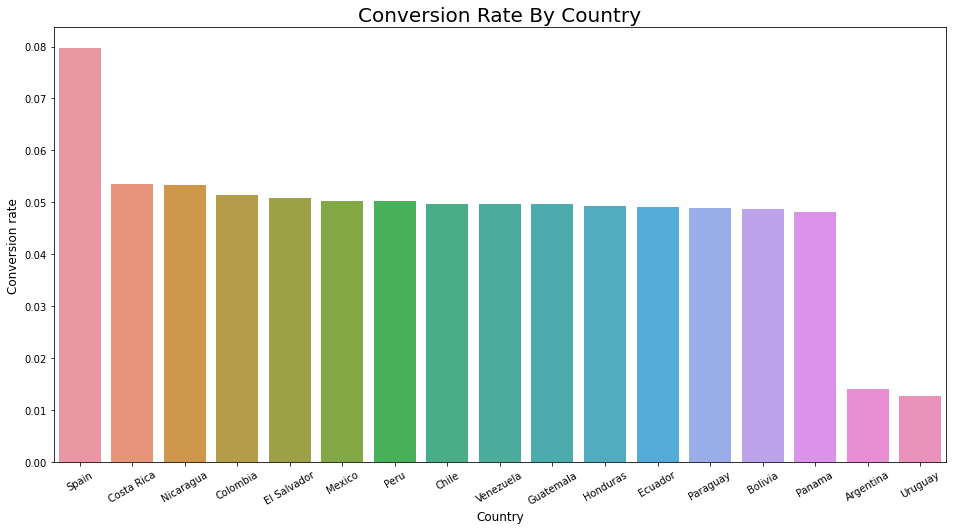

In [7]:
country_df=df.groupby('country')['conversion'].mean().reset_index().sort_values(by='conversion',ascending=False)
plt.subplots(figsize=(16,8))
# sns.set(rc={"figure.figsize":(20, 8)})
ax=sns.barplot(x='country',y='conversion',data=country_df)
ax.set_xlabel('Country',fontsize=12)
ax.set_ylabel('Conversion rate',fontsize=12)
ax.set_title('Conversion Rate By Country',fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

[Text(0, 0, 'Spain'),
 Text(1, 0, 'Costa Rica'),
 Text(2, 0, 'Nicaragua'),
 Text(3, 0, 'El Salvador'),
 Text(4, 0, 'Colombia'),
 Text(5, 0, 'Chile'),
 Text(6, 0, 'Mexico'),
 Text(7, 0, 'Honduras'),
 Text(8, 0, 'Guatemala'),
 Text(9, 0, 'Peru'),
 Text(10, 0, 'Venezuela'),
 Text(11, 0, 'Panama'),
 Text(12, 0, 'Bolivia'),
 Text(13, 0, 'Paraguay'),
 Text(14, 0, 'Ecuador'),
 Text(15, 0, 'Argentina'),
 Text(16, 0, 'Uruguay')]

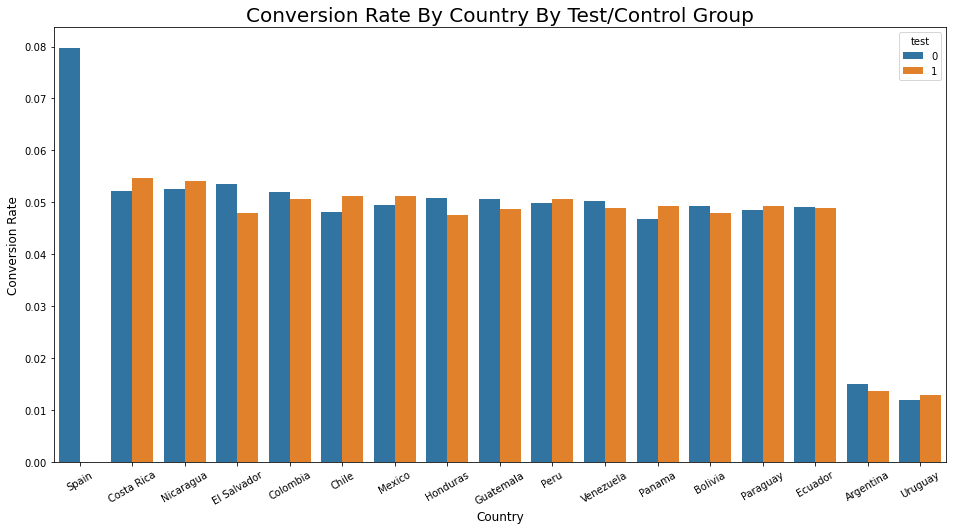

In [8]:
country_ab_df=df.groupby(['country','test'])['conversion'].mean().reset_index().sort_values(by='conversion',ascending=False)
plt.subplots(figsize=(16,8))
ax=sns.barplot(x='country',y='conversion',hue='test',data=country_ab_df)
ax.set_xlabel('Country',fontsize=12)
ax.set_ylabel('Conversion Rate',fontsize=12)
ax.set_title('Conversion Rate By Country By Test/Control Group',fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

#### Based on the Figures above, we can see that
* Spain indeed have higher conversion rate than other contries
* For AB testing,  some countries have higher conversion rate in the test group, while others have higher conversion in the control group. We may use T-test to check whether the difference between between control and test group in conversion rate is significant or not.

In [9]:
# remove the Spain from dataset since there is no Spain in test group 
df_ab=df[df['country']!='Spain']
# calculate the mean conversion rate for test and control groups
df_ab.groupby('test')['conversion'].mean()

test
0    0.048330
1    0.043425
Name: conversion, dtype: float64

The result shows that the conversion rate drops from 4.8 % to 4.3%. I will perform a t-test to confirm whether this difference is stastically significant.

In [10]:
import scipy.stats as stats
test_group=df_ab[df_ab['test']==1]['conversion']
control_group=df_ab[df_ab['test']==0]['conversion']
stats.ttest_ind(a=test_group,b=control_group,equal_var=False)

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)

Conversion Rate for users from original version (control group): 4.8 %, Users from localized version (test group): 4.3% This is approximately 10% drop in the conversion rate, which is significantly different based on the p value. 

### 4. Explain why that might be happening. Are the localized translations really worse?

#####  Likely reasons for this negtive test include

* The samples from control group and test group are not really random selected 
* The sample size is not large enough


#### 4.1 Enough sample size? 

In [11]:
df.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,12/3/2015,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,12/4/2015,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,12/4/2015,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,12/3/2015,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,11/30/2015,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


Text(0, 0.5, 'Conversion rate ratio of test/control')

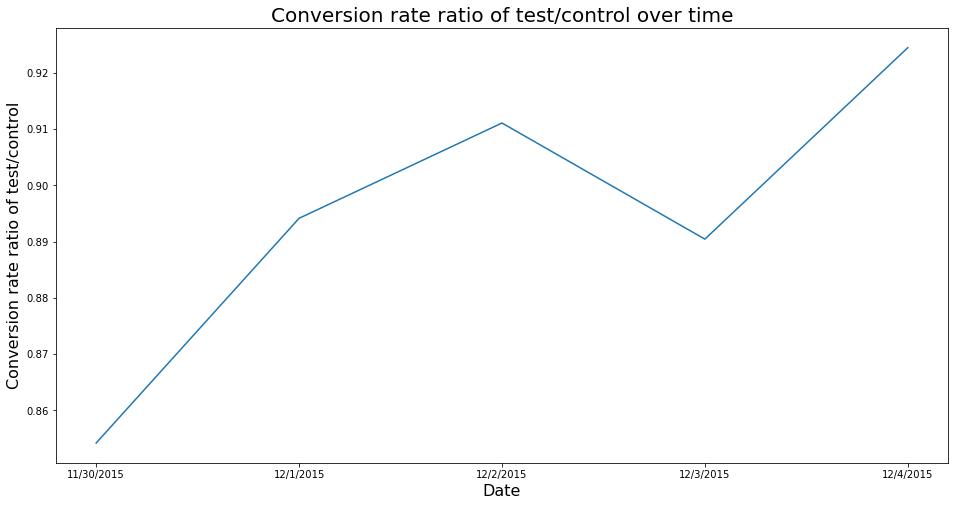

In [12]:
df_ss=df_ab.groupby(['date','test'])['conversion'].mean()
df_ss=df_ss.unstack().iloc[:,1]/df_ss.unstack().iloc[:,0]
plt.subplots(figsize=(16,8))
plt.plot(df_ss)
plt.title('Conversion rate ratio of test/control over time',fontsize=20)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Conversion rate ratio of test/control',fontsize=16)

##### Takeways: 
* The Control sample consistently performs better than test sample throughout the 5 days
* It is trending upward which could be a sign that the a/b test was for too short a time span
* Also, it may not capture the seasonal trend or pattern which should be remove from the test.

#### 4.2 Selection bias? 

In [14]:
len(df_ab[(df_ab['country']=='Mexico') & (df_ab['test']==1)])/len(df_ab[df_ab['country']=='Mexico'])

0.5002568413187635

In [26]:
rt_control=[]
rt_test=[]
p_value=[]
country=[]
sample_ratio=[]
for i in df_ab['country'].dropna().unique():
    control=df_ab[(df_ab['country']==i) & (df_ab['test']==0)]['conversion']
    test=df_ab[(df_ab['country']==i) & (df_ab['test']==1)]['conversion']
    ttest,pval=stats.ttest_ind(a=control,b=test,equal_var=False)
    ratio=len(df_ab[(df_ab['country']==i) & (df_ab['test']==1)])/len(df_ab[df_ab['country']==i])
    rt_control.append(control.mean())
    rt_test.append(test.mean())
    p_value.append(pval)
    country.append(i)
    sample_ratio.append(ratio)
       
pd.DataFrame({'Country':country,'Mean Conversion Rate for Control':rt_control,'Mean Conversion Rate for Test':rt_test,'p value':p_value,'%sample in test group':sample_ratio}).sort_values(by='%sample in test group')
    

,Country,Mean Conversion Rate for Control,Mean Conversion Rate for Test,p value,%sample in test group
13,Honduras,0.050906,0.047540,0.471463,0.491013
6,Nicaragua,0.052647,0.054177,0.780400,0.491447
11,Ecuador,0.049154,0.048988,0.961512,0.494432
12,Guatemala,0.050643,0.048647,0.572107,0.496066
1,Venezuela,0.050344,0.048978,0.573702,0.496194
5,El Salvador,0.053554,0.047947,0.248127,0.497492
3,Colombia,0.052089,0.050571,0.423719,0.498927
7,Peru,0.049914,0.050604,0.771953,0.498931
8,Costa Rica,0.052256,0.054738,0.687876,0.498964
0,Mexico,0.049495,0.051186,0.165544,0.500257


* Based on the p-value of AB Testing for each country, we fail to reject the null hypothesis. Therefore, the difference in conversion rate between test and control groups are not significant, which means that localized translation didn’t make things worse.
* Argentina and Uruguay have the lowest conversion rate of 1% and therer is nearly 80% of the samples from these two countries in the test group. Due to their small conversion rate and large samples into the test group, so there was a significant difference between the overall test conversion and control conversion rates.

### Conclusions

1. Given the fact of bias selection, we cannot give the conclusion about the difference between the two versions and that a localized translation did not make things worse as the team concluded.
2. Things that could be made for improvement for AB testing: 
* Make sure control group and test group are evenly split among the targets to avoid heavily imbalanced situations in Argentina and Uruguay
* It was run for only 5 days. we could run it for longer time to capture weekly / holiday patterns
